# Verbessertes Neural Net

- jetzt inklusive LAG Daten, da vorher v.a. die Sonntage schlecht vorhergesagt wurden

## Feature Engineering

In [1]:
#Fastenzeit Datum
FEATURES = [
    'Temperatur',
    'Windgeschwindigkeit',
    'KielerWoche',

    'Umsatz_lag_1',
    'Umsatz_lag_7',
    'Umsatz_rolling_7',

    'WettercodeExtremwetter',
    'WettercodeDunst',
    'WettercodeKlar',
    'WettercodeNachSchlechtemWetter',
    'WettercodeNebel',
    'WettercodeRegen',
    'WettercodeSchnee',

    'WarengruppeBread',
    'WarengruppeRolls',
    'WarengruppeCroissants',
    'WarengruppeConfectionery',
    'WarengruppeCake',
    'WarengruppeSeasonalBread',

    'WochentagFreitag',
    'WochentagSamstag',
    'WochentagSonntag',
    'WochentagUnterDerWoche',

    'Januar',
    'Februar',
    'Maerz',
    'April',
    'Mai',
    'Juni',
    'Juli',
    'August',
    'September',
    'Oktober',
    'November',
    'Dezember',
    
    'BewoelkungWolkenBedeckt',
    'BewoelkungWolkenBewoelkt',
    'BewoelkungWolkenKlar',
    
    'FeiertagChristiHimmelfahrt',
    'FeiertagErsterMai',
    'FeiertagOstermontag',
    'FeiertagPfingstmontag',
    'FeiertagTagDerDeutschenEinheit',
    'FeiertagHeiligabend',
    'FeiertagSilvester',
    'TagVorFeiertag',
    'Fastenzeit',

]

In [2]:
import pandas as pd
import numpy as np

In [3]:
train_data = pd.read_csv('../0_DataPreparation/data/data_final_mit_LAG/train_data.csv')
val_data = pd.read_csv('../0_DataPreparation/data/data_final_mit_LAG/validation_data.csv')
test_data = pd.read_csv('../0_DataPreparation/data/data_final_mit_LAG/test_data.csv')

In [4]:
import numpy as np
import pandas as pd

def create_lag_features(df, target_col='Umsatz', lags=[1, 7], rolling_windows=[7]):
    """
    Erstellt LAG- und Rolling-Features für eine Zeitreihe.
    """
    df = df.copy()
    
    # LAG-Features
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling-Features
    for window in rolling_windows:
        df[f'{target_col}_rolling_{window}'] = df[target_col].rolling(window).mean()
    
    return df


def recursive_predict(model, test_data, train_data, FEATURES, target_col='Umsatz'):
    """
    Rekursive Vorhersage: Nutzt eigene Predictions für fehlende LAG-Features.
    
    Parameters:
    -----------
    model : trainiertes Modell (z.B. tf.keras.Model)
    test_data : DataFrame mit Test-Daten
    train_data : DataFrame mit Train-Daten (für initiale LAGs)
    FEATURES : Liste der Feature-Namen
    target_col : Name der Zielvariable
    
    Returns:
    --------
    predictions : numpy array mit Vorhersagen
    """
    
    # Identifiziere LAG-Features
    lag_features = [f for f in FEATURES if 'lag' in f or 'rolling' in f]
    static_features = [f for f in FEATURES if f not in lag_features]
    
    print(f"LAG-Features: {lag_features}")
    print(f"Statische Features: {len(static_features)}")
    
    # Kombiniere Train + Test für kontinuierliche Historie
    combined = pd.concat([train_data, test_data], ignore_index=True)
    combined = combined.sort_values('Datum').reset_index(drop=True)
    
    # Finde Start-Index der Test-Daten
    test_start_idx = len(train_data)
    
    # Erstelle LAG-Features für gesamten Datensatz (nutzt echte Train-Werte)
    combined = create_lag_features(combined, target_col=target_col)
    
    # Array für Predictions
    predictions = []
    
    # Iteriere über jede Test-Zeile
    for i in range(test_start_idx, len(combined)):
        
        # Hole aktuelle Zeile
        current_row = combined.iloc[i:i+1].copy()
        
        # Prüfe, ob LAG-Features fehlen
        for lag_col in lag_features:
            if pd.isna(current_row[lag_col].values[0]):
                # Versuche, aus bisherigen Predictions zu berechnen
                if 'lag_1' in lag_col:
                    # LAG-1: Nutze letzte Prediction
                    if len(predictions) > 0:
                        current_row[lag_col] = predictions[-1]
                    else:
                        current_row[lag_col] = 0
                
                elif 'lag_7' in lag_col:
                    # LAG-7: Nutze Prediction von vor 7 Tagen
                    if len(predictions) >= 7:
                        current_row[lag_col] = predictions[-7]
                    else:
                        current_row[lag_col] = 0
                
                elif 'rolling_7' in lag_col:
                    # Rolling-7: Durchschnitt der letzten 7 Predictions
                    if len(predictions) >= 7:
                        current_row[lag_col] = np.mean(predictions[-7:])
                    elif len(predictions) > 0:
                        current_row[lag_col] = np.mean(predictions)
                    else:
                        current_row[lag_col] = 0
        
        # Prediction für aktuelle Zeile
        X = current_row[FEATURES].values
        
        # Je nach Modell-Typ anpassen:
        if hasattr(model, 'predict'):  # Keras/TensorFlow
            pred = model.predict(X, verbose=0)[0][0]
        else:  # Scikit-learn
            pred = model.predict(X)[0]
        
        predictions.append(pred)
        
        # Aktualisiere combined DataFrame mit Prediction (für nächste LAGs)
        combined.loc[i, target_col] = pred
        
        # Optional: Progress-Anzeige
        if (i - test_start_idx + 1) % 100 == 0:
            print(f"Fortschritt: {i - test_start_idx + 1}/{len(combined) - test_start_idx} Zeilen")
    
    return np.array(predictions)



## Implementation + Hyperparameters

In [5]:
# Aufteilen in Merkmale und Zielvariable
X_train = train_data[FEATURES]
y_train = train_data['Umsatz']

X_val = val_data[FEATURES]
y_val = val_data['Umsatz']

X_test = test_data[FEATURES]

In [6]:
# Skalierung der Merkmale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Aufbau des neuronalen Netzes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


2026-01-08 14:13:57.746239: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-08 14:13:58.119149: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 14:14:20.678934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 14:14:31.450918: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 192 (768.00 B)

In [8]:
# Training des Modells
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 65429.0469 - val_loss: 54954.2812
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64470.6602 - val_loss: 53641.4805
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62641.0508 - val_loss: 51640.4180
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 60004.7305 - val_loss: 48776.3906
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56729.6953 - val_loss: 46740.2617
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53008.3125 - val_loss: 40440.5898
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48987.8984 - val_loss: 36942.4414
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44869.2852 - val_loss: 34120.7695
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40940.0156 - val_loss: 29121.8535
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37223.6133 - val_loss: 26830.2695
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

## Evaluation Metrics

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

val_pred = model.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Validation RMSE: {rmse:.2f}")


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation RMSE: 130.64


In [10]:
test_pred = model.predict(X_test_scaled)

submission = pd.DataFrame({
    'id': test_data['id'],
    'Umsatz': test_pred.flatten()
})

submission.to_csv('../0_DataPreparation/data/submission_nn_clara_lag_fixed.csv', index=False)


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


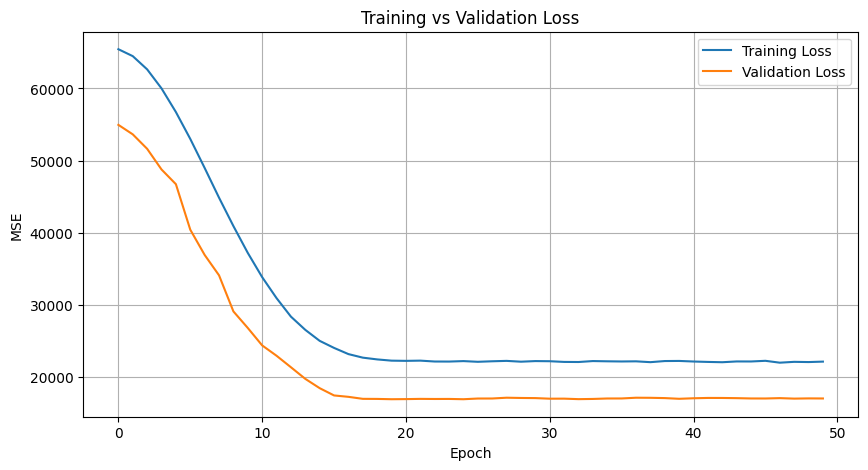

In [11]:
# Grafische Darstellung des Trainingsverlaufs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [12]:
# Berechnung und Ausgabe des MAPE auf dem Validierungsdatensatz
import numpy as np

def mape(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

y_val_pred = model.predict(X_val_scaled)

val_mape = mape(y_val, y_val_pred)
print(f"Validation MAPE (overall): {val_mape:.2f}%")



37/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation MAPE (overall): 82.00%


In [13]:
# MAPE pro Warengruppe
val_results = val_data.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = model.predict(X_val_scaled).flatten()

for wg in [
    'WarengruppeBread',
    'WarengruppeRolls',
    'WarengruppeCroissants',
    'WarengruppeConfectionery',
    'WarengruppeCake',
    'WarengruppeSeasonalBread'
]:
    subset = val_results[val_results[wg] == 1]
    mape_wg = mape(subset['y_true'], subset['y_pred'])
    print(f"{wg}: {mape_wg:.2f}%")



58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
WarengruppeBread: 84.80%
WarengruppeRolls: 37.70%
WarengruppeCroissants: 67.04%
WarengruppeConfectionery: 160.78%
WarengruppeCake: 21.04%
WarengruppeSeasonalBread: 326.88%


--> Modell noch nicht gut mit saisonalen Daten; hier noch Verbesserungspotential

In [14]:
# Berechnung und Ausgabe der Metriken
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


from tkinter import END
from tkinter.font import ITALIC
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Vorhersagen machen
y_train_pred = model.predict(X_train_scaled).flatten()
y_val_pred = model.predict(X_val_scaled).flatten()

class Colors:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    ITALIC = '\033[3m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Metriken berechnen
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{dataset_name}:")
    print(f"  MAE:  {Colors.GREEN}{mae:.2f} € {Colors.END} (Durchschnitt der absoluten Fehler)")
    print(f"  RMSE: {Colors.GREEN}{rmse:.2f} € {Colors.END} (Wurzel aus mittlerem quadratischen Fehler: bestraft große Fehler stärker)")
    print(f"  R²:   {Colors.YELLOW}{r2:.3f} {Colors.END} (Bestimmtheitsmaß: 0-1, höher = besser)")
    print(f"  MAPE: {Colors.GREEN}{mape:.2f} % {Colors.END} (Durschnittlicher prozentualer Fehler)")
    
    # print(f"\n{dataset_name}:")
    # print(f"  MAE:  {mae:.2f} € (durchschnittlicher Fehler) - Formel: (1/n) * Σ|y_true - y_pred|")
    # print(f"  RMSE: {rmse:.2f} € (bestraft große Fehler stärker) - Formel: √[(1/n) * Σ(y_true - y_pred)²]")
    # print(f"  R²:   {r2:.3f} (0-1, höher = besser) - Formel: 1 - (Σ(y_true - y_pred)² / Σ(y_true - ȳ)²)")
    # print(f"  MAPE: {mape:.2f} % (Fehler in Prozent) - Formel: (1/n) * Σ|(y_true - y_pred) / y_true| * 100")

evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_val, y_val_pred, "Validation")

print(f"")
print(f" Formeln:")
print(f"  MAE:  (Σ|y_true - y_pred|)/n")
print(f"  RMSE: √[(Σ(y_true - y_pred)²)/n]")
print(f"  R²:   1 - (Σ(y_true - y_pred)²/Σ(y_true - ȳ)²)")
print(f"  MAPE: (1/n) * Σ|(y_true - y_pred)/y_true| * 100")

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Training:
  MAE:  113.98 €  (Durchschnitt der absoluten Fehler)
  RMSE: 147.79 €  (Wurzel aus mittlerem quadratischen Fehler: bestraft große Fehler stärker)
  R²:   -0.000  (Bestimmtheitsmaß: 0-1, höher = besser)
  MAPE: 84.29 %  (Durschnittlicher prozentualer Fehler)

Validation:
  MAE:  103.10 €  (Durchschnitt der absoluten Fehler)
  RMSE: 130.64 €  (Wurzel aus mittlerem quadratischen Fehler: bestraft große Fehler stärker)
  R²:   -0.006  (Bestimmtheitsmaß: 0-1, höher = besser)
  MAPE: 82.00 %  (Durschnittlicher prozentualer Fehler)

 Formeln:
  MAE:  (Σ|y_true - y_pred|)/n
  RMSE: √[(Σ(y_true - y_pred)²)/n]
  R²:   1 - (Σ(y_true - y_pred)²/Σ(y_true - ȳ)²)
  MAPE: (1/n) * Σ|(y_true - y_pred)/y_true| * 100


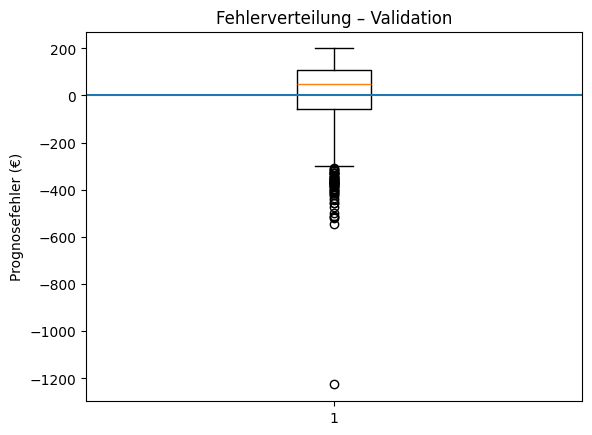

<Figure size 640x480 with 0 Axes>

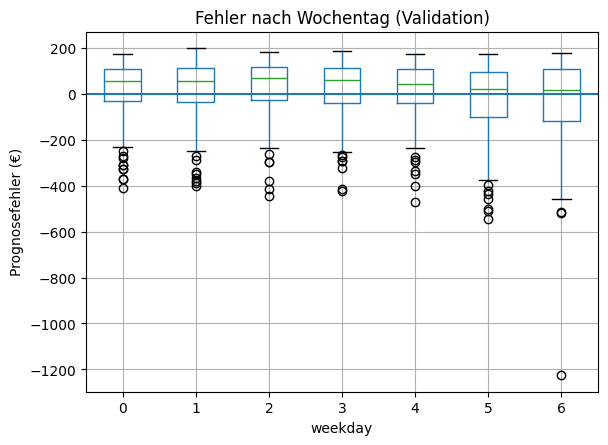

In [15]:
# Fehleranalyse und Visualisierung
train_errors = y_train_pred - y_train
val_errors   = y_val_pred   - y_val

import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(val_errors)
plt.axhline(0)
plt.ylabel("Prognosefehler (€)")
plt.title("Fehlerverteilung – Validation")
plt.show()

import pandas as pd

df_val = val_data.copy()
df_val["weekday"] = pd.to_datetime(df_val["Datum"]).dt.weekday
weekday_val = df_val["weekday"]

df_val_plot = pd.DataFrame({
    "error": val_errors,
    "weekday": weekday_val
})

plt.figure()
df_val_plot.boxplot(column="error", by="weekday")
plt.axhline(0)
plt.ylabel("Prognosefehler (€)")
plt.title("Fehler nach Wochentag (Validation)")
plt.suptitle("")
plt.show()


Deutliche Verbesserung sichtbar für Sonntage

To-Do (Zukunft): Saisonalitätsvorhersagen optimieren